# Recommender System on Retail data on Vertex-AI using PySpark





## Table Of Contents
* [Overview](#section-1)
* [Dataset](#section-2)
* [Objective](#section-3)
* [Costs](#section-4)
* [Create a DataProc cluster with component gateway enabled and JupyterLab extension](#section-5)
* [Connect to the cluster from the notebook](#section-6)
* [Explore the data](#section-7)
* [Define the ALS Model](#section-8)
* [Evaluate the model](#section-9)
* [Save the ALS model to GCS](#section-10)  
* [Write the recommendations to Bigquery](#section-11)
* [Clean up](#section-12)

## Overview
<a name="section-1"></a>

Recommender systems are powerful tools that model existing customer behavior to generate recommendations. These models generally build complex matrices and map out existing customer preferences in order to find intersecting interests and offer recommendations. These matrices can be very large and will benefit from distributed computing and large memory pools. This is a perfect application for Vertex-AI notebooks running PySpark on DataProc cluster.


## Dataset
<a name="section-2"></a>

This notebook uses the following dataset in Bigquery : ```looker-private-demo.retail```. It can be accessed by pinning the ```looker-private-demo``` project in Bigquery. Instead of going to Bigquery UI, this process can be performed from the current Jupyter environment(on Vertex-AI's managed-instance) itself. Vertex-AI's managed instances support browsing through the datasets and tables from Bigquery through its **Bigquery In Notebooks** feature. 

<img src="images/Bigquery_UI_new.PNG"></img>

In this dataset, ```retail.order_items``` table will be used to train the recommendation system using PySpark. This table contains information on various orders related to the users and items(products) in the dataset.



## Objective
<a name="section-3"></a>

The objective of this tutorial is to build a recommendation model with [Collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering) approach using the interactive PySpark features offered by the managed instances on Vertex-AI. To do so, a remotely connected DataProc cluster and the <a href="http://dl.acm.org/citation.cfm?id=1608614"><b>Alternating Least Squares(ALS)</b></a> method implemented in the PySpark's MLlib library are used.

The steps performed in this notebook are as follows :
1. Remotely connect to a Dataproc cluster with Pyspark and JupyterLab from the notebook.
2. Exploring the dataset in Bigquery from the notebook.
3. Preprocessing the data.
4. Training a PySpark ALS model on the data.
5. Evaluating the ALS model.
6. Generating recommendations.
7. Saving the recommendations to a Bigquery using Pyspark-Bigquery connector.
8. Saving the ALS model to a Cloud Storage Bucket.
9. Cleaning up the resources.


## Costs
<a name="section-4"></a>
This tutorial uses the following billable components of Google Cloud:

* Vertex AI
* Dataproc
* Bigquery
* Cloud Storage

Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing), [Dataproc pricing](https://cloud.google.com/dataproc/pricing), [Bigquery
pricing](https://cloud.google.com/bigquery/pricing) and [Cloud Storage
pricing](https://cloud.google.com/storage/pricing) and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Before you begin

As the ALS model approach is compute intensive and could take a lot of time to train on a regular notebook environment, a Dataproc cluster with PySpark environemnt is used in this notebook. The steps taken to connect to the cluster are as follows : 


## Create a DataProc cluster with component gateway enabled and JupyterLab extension
<a name="section-5"></a>
The following gcloud command can be executed to create the cluster.

In [ ]:
PROJECT = "your-project-name"
CLUSTER_NAME = "your-cluster-name"
CLUSTER_REGION = "your-cluster-region"
CLUSTER_ZONE = "your-cluster-zone"
MACHINE_TYPE = "your=machine-type"

In [ ]:
! gcloud dataproc clusters create $CLUSTER_NAME \
--enable-component-gateway \
--region $CLUSTER_REGION \
--zone $CLUSTER_ZONE \
--single-node \
--master-machine-type $MACHINE_TYPE \
--master-boot-disk-size 100 \
--image-version 2.0-debian10 \
--optional-components JUPYTER \
--project $PROJECT

Alternatively, the cluster can be created through the Dataproc console as well. Additional settings like network configuratons, service-accounts etc. can be configured there if required. Among all the settings while configuring the cluster, the following steps are needed to be followed for this tutorial :

- Provide a name for the cluster.
- Select a region and zone for the cluster.
- Select the cluster type as single-node. For small and proof-of-concept usecases, it is recommended to select a single-node cluster. If needed, other types can also be selected based on the requirement.
- Enable Component gateway.
- In the optional components, select Jupyter Notebook.
- (optional) Select the machine-type (preferably high-mem machine type).
- Create the cluster.

## Connect to the cluster from the notebook
<a name="section-6"></a>
When the created Dataproc cluste is running, the corresponding runtime can be remotely set as a kernel in the notebook. The created cluster's name will appear in the list of kernels that can be selected for this notebook. Select the Python3 kernel on the remote cluster environment for this tutorial.

<img src="images/cluster_kernel_selection.png"></img>

***Note :**
- The remote kernels might take some time(~3min.) to show up in the list of kernels.
- PySpark code in this tutorial can be run on either PySpark or Python3 kernel on the remote Dataproc cluster. But to run the optional part where the recommendations are saved to a Bigquery table using a Bigquery connector, it is recommended that Python3 kernel(remote) is selected.

## Tutorial 

## Explore the data
<a name="section-7"></a>


Vertex-AI's managed-instances provide us the ability to explore the Bigquery content from its **Bigquery In Notebooks** pane on left. This feature allows us to look at the meta-data and preview of the table-content, query the table and also get a description of the data in the tables.

<img src="images/BQ_view_table_new.PNG"></img>

Check the distribution of the STATUS field.

#@bigquery
SELECT STATUS, COUNT(*) order_count FROM looker-private-demo.retail.order_items GROUP BY 1

Join the ```order_items``` table with the ```inventory_items``` table from the same dataset to retrieve the PRODUCT_IDs for the orders.

#@bigquery
WITH user_prod_table AS (
SELECT USER_ID, PRODUCT_ID, STATUS FROM looker-private-demo.retail.order_items AS a
join
(SELECT ID, PRODUCT_ID FROM looker-private-demo.retail.inventory_items) AS b
on a.inventory_item_id = b.ID )

SELECT USER_ID, PRODUCT_ID, STATUS from user_prod_table

To fetch the data into into the current environment as a dataframe, press the **Query and load as DataFrame** button and execute the generated code stub.

*Note : By default the data is loaded into "df" variable and it could be changed before executing the cell if required.*

In [1]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

query = """WITH user_prod_table AS (
SELECT USER_ID, PRODUCT_ID, STATUS FROM looker-private-demo.retail.order_items AS a
join
(SELECT ID, PRODUCT_ID FROM looker-private-demo.retail.inventory_items) AS b
on a.inventory_item_id = b.ID )

SELECT USER_ID, PRODUCT_ID, STATUS from user_prod_table"""
job = client.query(query)
df = job.to_dataframe()

### Preprocess the Data

To run PySpark's ALS method on the existing data, it is necessary that there are some fields to quantify the relation between the USER_IDs and the PRODUCT_IDs like for example *ratings given by the user*. If such fields alredy exist in the data, they can be treated as an *explicit feedback* for the ALS model. Otherwise, the fields indicative of such relation can be given as an *implicit feedback*. More about the feedbacks for PySpark's ALS method can be checked [here](https://spark.apache.org/docs/2.2.0/ml-collaborative-filtering.html#explicit-vs-implicit-feedback).

In the current dataset, as there are no such numerical fileds, the STATUS field is further used to quantify the association between a USER_ID and  a PRODUCT_ID. Based on when they occur during an order lifecycle and how likely the user is going to like the order, the STATUS field is quantified by assigning the following ratings : 
- Cancelled - 1
- Returned - 2
- Processing - 3
- Shipped - 4
- Complete - 5

These ratings given are subjective and can be modified according to the usecase.

In [2]:
score_mapping = {"Cancelled" : 1, 
            "Returned" : 2,
            "Processing" : 3, 
            "Shipped" : 4,
            "Complete" : 5}
df['RATING'] = df['STATUS'].map(score_mapping)

Check the distribution of the newly generated RATING field.

<AxesSubplot:ylabel='Frequency'>

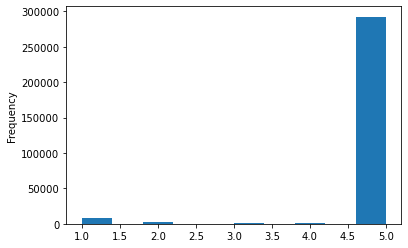

In [3]:
df['RATING'].plot(kind='hist')

Load the required methods and classes from PySpark MLlib.

In [4]:
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

Generate a Spark session with Bigquery-Spark connector configured.

*Note : If the notebook is connected to a Dataproc cluster, the session object would show "yarn" as the Master.*

In [5]:
spark = SparkSession.builder \
.appName('Recommendations') \
.config('spark.jars', 'gs://spark-lib/bigquery/spark-bigquery-latest_2.12.jar') \
.getOrCreate()

spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Convert the pandas dataframe to a spark dataframe for further processing.

In [6]:
spark_df=spark.createDataFrame(df[['USER_ID', 'PRODUCT_ID', 'RATING']]) 
spark_df.printSchema()
spark_df.show()

root
 |-- USER_ID: long (nullable = true)
 |-- PRODUCT_ID: long (nullable = true)
 |-- RATING: long (nullable = true)



+-------+----------+------+
|USER_ID|PRODUCT_ID|RATING|
+-------+----------+------+
|   3223|     20139|     1|
|   6586|     27065|     1|
|   7356|     13792|     1|
|   7595|     28340|     1|
|   8314|     18045|     1|
|  12845|      1626|     1|
|  15135|      2428|     1|
|  15399|     16113|     1|
|  16919|     22707|     1|
|  17022|     18979|     1|
|  17096|     28302|     1|
|  19079|      6411|     1|
|  19855|      3466|     1|
|  24743|     12761|     1|
|  29189|     20547|     1|
|  31575|      3459|     1|
|  31693|     17597|     1|
|  37735|      7573|     1|
|  38373|       129|     1|
|  39619|     20542|     1|
+-------+----------+------+
only showing top 20 rows



### Split the data into Train and Test

In [7]:
(train, test) = spark_df.randomSplit([0.8, 0.2], seed = 36)
train.count(), test.count()

(245185, 60883)

## Define the ALS Model
<a name="section-8"></a>

The PySpark ALS recommender, Alternating Least Squares, is a matrix factorization algorithm. The idea is to build a matrix that maps users to actions. The actions can be reviews, purchases, various options taken, etc. Due to the complexity and size of the matrix, PySpark can run the algorithm in parallel.

ALS will attempt to estimate the rating matrix R as the product of two lower-rank matrices, X and Y. Typically these approximations are called ‘factor’ matrices. During each iteration, one of the factor matrices is held constant, while the other is solved for using least squares. The newly-solved factor matrix is then held constant while solving for the other factor matrix.

PySpark uses a blocked implementation of the ALS factorization algorithm that groups the two sets of factors (referred to as “users” and “products”) into blocks and reduces communication by only sending one copy of each user vector to each product block on each iteration, and only for the product blocks that need that user’s feature vector.

Essentially instead of finding the low-rank approximations to the rating matrix R, this finds the approximations for a preference matrix P where the elements of P are 1 if r > 0 and 0 if r <= 0. The ratings then act as ‘confidence’ values related to the strength of indicated user preferences rather than explicit ratings given to items (more information about PySpark's ALS can be found [here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.recommendation.ALS.html)).

In [8]:
als = ALS(
         userCol="USER_ID", 
         itemCol="PRODUCT_ID",
         ratingCol="RATING", 
         nonnegative = True, 
         implicitPrefs = False,
         coldStartStrategy="drop"
)

ALS model tries to predict the ratings between users and items and so RMSE can be used for evaluating the model.

In [9]:
evaluator = RegressionEvaluator(
           metricName="rmse", 
           labelCol="RATING", 
           predictionCol="prediction") 

Define a hyperparameter grid for Cross-Validation.

In [10]:
param_grid = ParamGridBuilder() \
            .addGrid(als.rank, [10, 50]) \
            .addGrid(als.regParam, [.01, .1, 0.2]) \
            .build()
print ("No. of settings to be tested: ", len(param_grid))

No. of settings to be tested:  6


Perform Crossvalidation and save the best model.

In [11]:
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3)
model = cv.fit(train)
best_model = model.bestModel

In [12]:
print("##Parameters for the Best Model##")
print("Rank:", best_model._java_obj.parent().getRank())
print("MaxIter:", best_model._java_obj.parent().getMaxIter())
print("RegParam:", best_model._java_obj.parent().getRegParam())

##Parameters for the Best Model##
Rank: 10
MaxIter: 10
RegParam: 0.2


## Evaluate the model
<a name="section-9"></a>
Evaluate the model by computing the RMSE on the train and test data.

In [13]:
# View the rating predictions by the model on train and test sets
train_predictions = best_model.transform(train)
train_RMSE = evaluator.evaluate(train_predictions)

test_predictions = best_model.transform(test)
test_RMSE = evaluator.evaluate(test_predictions)

print("Train RMSE ", train_RMSE)
print("Test RMSE " , test_RMSE)

Train RMSE  0.3995716034391009
Test RMSE  0.9899883384950502


### Generate recommendations for all users

Required number of recommendations for the users can be generated using the ALS model's *recommendForAllUsers()* method.

In [14]:
# Generate 10 product recommendations for all users
nrecommendations = best_model.recommendForAllUsers(10)
nrecommendations.limit(10).show()

+-------+--------------------+
|USER_ID|     recommendations|
+-------+--------------------+
|      1|[{649, 5.9176435}...|
|      6|[{4641, 5.7179666...|
|     12|[{17687, 5.396861...|
|     13|[{17065, 5.295532...|
|     16|[{17065, 5.622257...|
|     22|[{17065, 5.273835...|
|     26|[{4641, 5.58397},...|
|     27|[{19560, 5.433427...|
|     28|[{17065, 5.639814...|
|     31|[{17065, 5.533632...|
+-------+--------------------+



### Generate recommendations for a specific user

The earlier step already generated and stored the specified number of product recommendations for all users in *nrecommendations* dataframe object. To obtain recommendations for a single user, this dataframe object can be queried simply.

In [15]:
## get product recommendations for the selected user (USER_ID = 1)
nrecommendations.where(nrecommendations.USER_ID == 1).select("recommendations.PRODUCT_ID", "recommendations.rating").collect()

[Row(PRODUCT_ID=[649, 1842, 2803, 23373, 9889, 14588, 10457, 10411, 28524, 6818], rating=[5.9176435470581055, 5.787947177886963, 5.755666732788086, 5.682463645935059, 5.664970397949219, 5.557429313659668, 5.509372234344482, 5.422667026519775, 5.34205436706543, 5.230965614318848])]

## Save the ALS model to GCS (optional)
<a name="section-10"></a>
Pyspark's ALS.save() method will create a folder at the specified path where it saves the trained model. With GCS file browser available in the managed-instance environment, this method can directly save the model to a GCS bucket.

The following two cells can be executed to create a new bucket in Cloud Storage if not created already. 

In [ ]:
BUCKET_REGION = "your-bucket-region"
BUCKET_NAME = "your-bucket-name

In [ ]:
! gsutil mb -l $REGION $BUCKET_NAME

Use the ALS object's *.save()* function to write the model to the GCS bucket. 

In [16]:
## Save the trained model
GCS_MODEL_PATH = "gs://your-bucket-name/recommender_systems/"
best_model.save(GCS_MODEL_PATH+"rcmd_model")

## Write the recommendations to Bigquery (optional)
<a name="section-11"></a>
In order to serve the recommendations to the end-users or any applications, the output from the *recommendForAllUsers()* method can be saved to a Bigquery table using Spark's Bigquery connector.


### Create a Dataset in Bigquery
The following cell creates a new dataset in Bigquery.

#@bigquery
-- create a dataset in Bigquery
CREATE SCHEMA recommender_sys
OPTIONS(
  location="us"
  )

### Write the Recommendations to Bigquery

PySpark's Bigquery-connector requires two necessary fields i.e., *Bigquery Table name* and a *GCS path to write the temporary files* while saving the model. These two fields can be provided accordingly while writing the recommendations to Bigquery.

In [17]:
DATASET = "your-dataset-name"
TABLE = "your-bigquery-table-name"
GCS_TEMP_PATH = "your-gcs-path"

nrecommendations.write \
  .format("bigquery") \
  .option("table","{}.{}".format(DATASET, TABLE)) \
  .option("temporaryGcsBucket", GCS_TEMP_PATH) \
  .mode('overwrite') \
  .save()

## Clean up
<a name="section-12"></a>
To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

In [ ]:
## remove the Bigquery dataset created for storing the recommendations and all of its tables
! bq rm -r -f -d $PROJECT:$DATASET

## remove the GCS bucket created and all of its tables
gsutil rm -r gs://$BUCKET_NAME

In [ ]:
## delete the created Dataproc cluster 
! gcloud dataproc clusters delete $CLUSTER_NAME --region=$CLUSTER_REGION